In [55]:
import numpy as np
import pandas as pd
import math
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [56]:

#Fluxo de Caixa  - A estrutura é baseada no Livro do Marco Antonio  - Analiser e Investimento em Opçoes Reais 

tempo= 25 #anos de produção

#Premissas Economicas

depr=0.7 #Investimento deprecivavel
adepr=15 #anos de depreciacao

#Curva S
a1_s=0.093 #porcentagem
a2_s=0.532
a3_s=1- a1_s - a2_s  #soma deve ser igual a 1



roy=0.1 #royalties
tax= 0.34 #porcentagem do leao - imposto de renda


#taxa de desconto e retorno sem risco

mi=0.1 #retorno total do ativo
r= 0.065 #r antes dos impostos

# Equity e Divida
e_por=0.7
d_por= 1 - e_por #soma deve dar um


tx_desc=(r*(1-tax)*d_por) + (mi*e_por) #Custo Médio Ponderado do Capital
#tx_desc=0.1

delta=r*(1-tax) #taxa de dividendos


#Preço do Barril. Vai variar
#alpha é o drift da série
alpha_a=0.015 


5446    210822.70150829357    86324.89781653072
7877.0    313406.251315591    129627.10449582517
2119.0    73663.88100767709    28658.979174183136


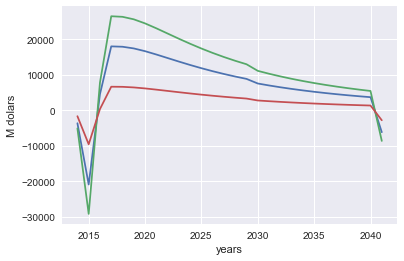

In [57]:
cb=['Anos','Desconto','Producao_m','LN','Inv_t_m','Inv_ndep_m', 'Depr_m','Preco_m','PDQ_m','Receita_m','C_OP_Var_m','C_OP_Fixo_m',
    'Royalties_m','Abandono_m','FCT_m','Imposto_m', 'FCL_m']
df=pd.DataFrame(index=range(1,tempo+4),columns=cb) #index 2 anos p producao e 1 de abandono
df.Anos=df.index +2013 #ano de inicio
df.Desconto=np.exp((-tx_desc)*(df.index-1))


for B_n in ((5446,7877.00,2119.00)):
    #parametro Q - PRODUCAO - OLEO RECUPERADO
    #Q=df.Producao.sum()
    Q=B_n*((math.pow(10,6))/(365))
    sigma=0.91
    media=2.5

    #0.91 / 2.5 
    
    
    
    #Produção MODELADA
    df.loc[1,'LN']=(1/(0.1*sigma*np.sqrt(2*np.pi)))*np.exp(-1*(np.power(((np.log(0.01))-media),2))/(2*np.power(sigma,2)))
    for i in range(3,len(df)):
        df.loc[i,'LN']=(1/((i-1*sigma*np.sqrt(2*np.pi)))*np.exp(-1*(np.power(((np.log(i-1))-media),2))/(2*np.power(sigma,2))))

    df.Producao_m=(1/(df.LN.sum()))*Q*df.LN


    #Investimento _MODELADO
    #Investimento em Milhoes
    Inv_t_m= 7.1229*(B_n) + 4956.6
    #Inv_t_m= (4*math.pow(10,-7))*(math.pow(B_n,3)) -(0.0049)*np.power(B_n/1000,2)+ (22.936*B_n) -1543.4
    #Investimento Total MODELADO
    df.loc[1,'Inv_t_m']=Inv_t_m*a1_s
    df.loc[2,'Inv_t_m']=Inv_t_m*a2_s
    df.loc[3,'Inv_t_m']=Inv_t_m*a3_s

    #Investimento Nao Depreciavel MODELADO
    df.loc[1,'Inv_ndep_m']=Inv_t_m*a1_s*(1-depr)
    df.loc[2,'Inv_ndep_m']=Inv_t_m*a2_s*(1-depr)
    df.loc[3,'Inv_ndep_m']=Inv_t_m*a3_s*(1-depr)

    #Depreciação MODELADO
    df.loc[3:adepr+1,'Depr_m']= Inv_t_m*depr/adepr


    #Preço do Barril +A MODELAR

    df.loc[1,'Preco_m']=P
    for anos in range(2,tempo+4):
        df.loc[anos,'Preco_m']=P*np.exp(alpha_a*anos)
    #P_t D_t Q_t MODELADO

    df.PDQ_m=df.Producao_m*df.Desconto*df.Preco_m


    #Receita Milhoes dolares/ano MODELADO

    df.Receita_m=(df.Producao_m*df.Preco_m)*365/(math.pow(10,6))

    #Custo operacional Variavel milhoes de dolares/anos MODELADO
    coV_m= (1*math.pow(10,-7))*(math.pow(B_n,2)) -(0.0018)*(B_n)+10.162
    df.C_OP_Var_m=(df.Producao_m*coV_m)*365/(math.pow(10,6))

    #Custo Fixo milhoes de dolares/anos MODELADO
    #coF_m= (1*math.pow(10,-5))*(math.pow(B_n,2)) +(0.1642)*(B_n)+59.43
    coF_m= 0.0909*(B_n) + 104.46
    df.C_OP_Fixo_m=np.where(df.Producao_m>0.5,coF_m,0)

    #Royalties milhoes de dolares/ano MODELADO
    df.Royalties_m=df.Receita_m*roy

    #Abandono MODELADO
    #abondo_m= (7*math.pow(10,-8))*(math.pow(B_n,3)) -(0.001)*np.power(B_n,2)+ (4.5029*B_n) -176.1
    abondo_m= 1.5295*(B_n) + 1019.1
    #abondo_m=0
    df.loc[tempo+3,'Abandono_m']=abondo_m

    #fillnan
    df= df.fillna(0)

    #Fluxo de Caixa Tributavel milhoes ano MODEALDO
    df.FCT_m= df.Receita_m - df.Inv_ndep_m -df.Depr_m - df.C_OP_Var_m  -df.C_OP_Fixo_m - df.Royalties_m - df.Abandono_m

    #Imposto de Renda milhoes ano MODELADO
    df.Imposto_m=df.FCT_m*tax

    #Fluxo de Caixa Liquido MODELADO

    df.FCL_m= df.FCT_m + df.Depr_m -df.Imposto_m  -(df.Inv_t_m- df.Inv_ndep_m)

    #VPL MODELADO
    VPL_m=(df.FCL_m*df.Desconto).sum()

    #Investimento a tempo presente MODELADO

    I_t0_m=((df.Inv_t_m*df.Desconto)-(tax*(df.Inv_ndep_m*df.Desconto))-(tax*(df.Depr_m*df.Desconto))+((1-tax)*(df.Abandono_m*df.Desconto))).sum()

    #Valor Presente MODELADO
    V_t0_m= VPL_m+I_t0_m


    #Razao V_to/I_to MODELADO

    V_I=V_t0_m/I_t0_m


    #Reserva em milhoes de barris
    B_m=(df.Producao_m*(365)/(math.pow(10,6))).sum()


    #modelo Paramétrico de VPL VPL=qBP -I
    q_m=V_t0_m/(B_m*df.Preco_m.mean())

    #Break even
    breven_m=I_t0_m/(q_m*B_m)
    print(B_n,'','','',df.FCL_m.sum(),'','','',VPL_m)
    
    plt.plot(df.Anos,df[['FCL_m']])
    plt.xlabel('years')
    plt.ylabel('M dolars')
    #plt.legend('Produção %.2f' %(B_n))
    #fig, ax = plt.subplots()
    #ax.fill(df.Anos,df.Producao_m, zorder=10)
    #ax.grid(True, zorder=5)
    #plt.legend()






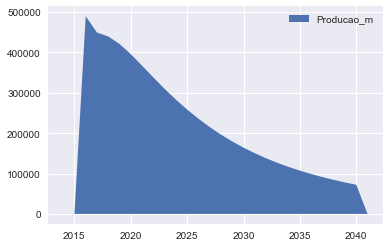

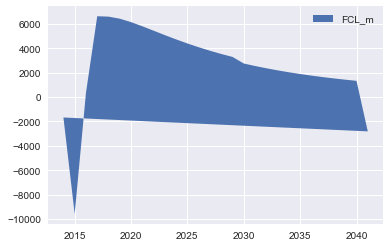

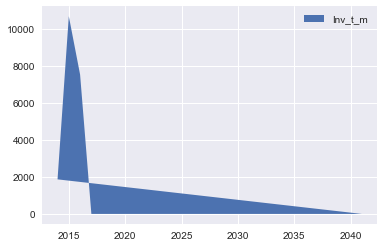

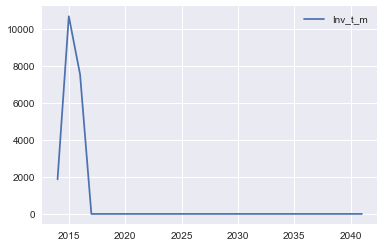

In [58]:
fig, ax = plt.subplots()
ax.fill(df.Anos,df.Producao_m, zorder=10)
ax.grid(True, zorder=5)
plt.legend()

fig1, ax = plt.subplots()
ax.fill(df.Anos,df.FCL_m, zorder=10)
ax.grid(True, zorder=5)
plt.legend()


fig2, ax = plt.subplots()
ax.fill(df.Anos,df.Inv_t_m, zorder=10)
ax.grid(True, zorder=5)
plt.legend()


fig3, ax = plt.subplots()
plt.plot(df.Anos,df.Inv_t_m, zorder=10)
ax.grid(True, zorder=5)
plt.legend()



In [59]:
df.head()

,Anos,Desconto,Producao_m,LN,Inv_t_m,Inv_ndep_m,Depr_m,Preco_m,PDQ_m,Receita_m,C_OP_Var_m,C_OP_Fixo_m,Royalties_m,Abandono_m,FCT_m,Imposto_m,FCL_m
1,2014,1.000000,6.406233e-07,2.534696e-13,1864.652334,559.395700,0.000000,70.000000,4.484363e-05,1.636792e-08,1.589282e-09,0.0000,1.636792e-09,0.0,-559.395700,-190.194538,-1674.457796
2,2015,0.920471,0.000000e+00,0.000000e+00,10666.613353,3199.984006,0.000000,72.131817,0.000000e+00,0.000000e+00,0.000000e+00,0.0000,0.000000e+00,0.0,-3199.984006,-1087.994562,-9578.618791
3,2016,0.847266,4.896455e+05,1.937336e-01,7518.759412,2255.627824,935.667838,73.221950,3.037687e+07,1.308627e+04,1.214731e+03,297.0771,1.308627e+03,0.0,7074.539379,2405.343389,341.732239
4,2017,0.779884,4.491916e+05,1.777276e-01,0.000000,0.000000,935.667838,74.328558,2.603858e+07,1.218653e+04,1.114372e+03,297.0771,1.218653e+03,0.0,8620.763773,2931.059683,6625.371928
5,2018,0.717861,4.395683e+05,1.739200e-01,0.000000,0.000000,935.667838,75.451891,2.380875e+07,1.210569e+04,1.090498e+03,297.0771,1.210569e+03,0.0,8571.874312,2914.437266,6593.104884
